We will be creating a **classifcation model to predict if a company goes bankrupt or not**.

The data collected is from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.

In [7]:
import pandas as pd
# import shap
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report, precision_recall_curve, average_precision_score

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving taiwan_econ_journal.csv to taiwan_econ_journal.csv


In [8]:
df = pd.read_csv('taiwan_econ_journal.csv')
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


The target variable is the 'Bankrupt?' column. There are **no missing values and no duplicate values**. All columns are numeric.

In [9]:
df['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

#### Functions

In [10]:
def split_data(df, target_column='Bankrupt?'):
  """
  Prepares the data for modeling by splitting into features and target variable,
  and then performing a stratified split for training and testing sets.

  Args:
    df: The pandas DataFrame containing the data.
    target_column: The name of the target column.

  Returns:
    X_train: The training features.
    X_test: The testing features.
    y_train: The training target variable.
    y_test: The testing target variable.
  """

  X = df.drop(target_column, axis=1)  # Features
  y = df[target_column]  # Target variable

  # Stratified split
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

  return X_train, X_test, y_train, y_test

In [11]:
def apply_smote(X_train, y_train, random_state=42):
  """
  Applies SMOTE to balance the class distribution in the training data.

  Args:
    X_train: The training features.
    y_train: The training target labels.
    random_state: Random seed for reproducibility.

  Returns:
    X_train_resampled: The resampled training features.
    y_train_resampled: The resampled training target labels.
  """

  smote = SMOTE(random_state=random_state)
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

  return X_train_resampled, y_train_resampled

In [12]:
def train_model(X_train, y_train, model_type, model_params):
  """
  Trains the specified model on the given training data and hyperparameters.

  Args:
    X_train: The training features.
    y_train: The training labels.
    model_type: The type of model to train ('random_forest', 'xgboost', etc.).
    model_params: A dictionary of hyperparameters for the model.

  Returns:
    The trained model.
  """

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)

  if model_type == 'random_forest':
      model = RandomForestClassifier(**model_params)
  elif model_type == 'xgboost':
      model = XGBClassifier(**model_params)
  # Add more model types as needed

  # pipeline = Pipeline([
  #     ('scaler', StandardScaler()),
  #     ('model', model)
  # ])

  model.fit(X_train, y_train)
  return model

In [13]:
def make_y_predictions(model, X_test):
  """
  Makes predictions on the given test data using the trained Random Forest model.

  Args:
    model: The trained Random Forest Classifier model.
    X_test: The test features.

  Returns:
    The predicted labels for the test data.
  """
  y_predictions = model.predict(X_test)
  return y_predictions

In [14]:
def evaluate_metrics(model, X_test, y_test):
  """
  Evaluates the model's performance using F1-score and SHAP values.

  Args:
    model: The trained model.
    X_test: The test features.
    y_test: The true labels for the test data.

  Returns:
    None
  """

  y_pred = make_y_predictions(model, X_test)

  # Calculate and print metrics
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, y_pred_proba)

  print("F1-Score:", f1)
  print("Precision:", precision)
  print("Recall:", recall)
  print("AUC-ROC:", roc_auc)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

In [15]:
def visualize_metrics(model, X_test, y_test):
  """
  Visualizes various classification metrics.

  Args:
    y_true: True labels.
    y_pred: Predicted labels.
    y_prob: Predicted probabilities.
  """
  y_pred = make_y_predictions(model, X_test)
  y_prob = model.predict_proba(X_test)[:, 1]

  # Confusion Matrix
  print(f"\n{model}\n Confusion Matrix:")
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Non-Bankrupt', 'Bankrupt'],
              yticklabels=['Non-Bankrupt', 'Bankrupt'])
  plt.title(f'{model} Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  # ROC Curve
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()


  # Precision-Recall Curve
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  average_precision = average_precision_score(y_test, y_prob)
  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower right")
  plt.show()

In [19]:
def interpret_model_shap(model, X_train_resampled, df, target_column='Bankrupt?'):
  """
  Interprets the model using SHAP values.

  Args:
    model: The trained model.
    X_test: The test features.
  """
  X = df.drop(target_column, axis=1)

  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_train_resampled)
  shap.summary_plot(shap_values, X_train_resampled, feature_names=X.columns)

In [16]:
def interpret_model_feat_importance(model, X_train_resampled, df, target_column='Bankrupt?'):
  X = df.drop(target_column, axis=1)

  feat_importance_df = pd.DataFrame({
      'Feature': X.columns,
      'Importance': rf_model.feature_importances_
  }).sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(10, 8))
  plt.barh(feat_importance_df['Feature'][:20], feat_importance_df['Importance'][:20], color='skyblue')
  plt.title('Top 20 Feature Importances (Random Forest)')
  plt.gca().invert_yaxis()
  plt.show()

#### Random Forest Classifier

In [17]:
X_train, X_test, y_train, y_test = split_data(df)
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

In [18]:
rf_model = train_model(X_train_resampled, y_train_resampled, model_type='random_forest', model_params={'n_estimators':100, 'random_state':42})

In [ ]:
# # With grid search
# rf_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }
# rf_model_grid = train_model_gridsearch(X_train_resampled, y_train_resampled, 
#                                        model_type='random_forest', 
#                                        model_params={'n_estimators':100, 'random_state':42}, 
#                                        use_gridsearch=True, param_grid=rf_param_grid, scoring='f1', cv=5)

In [19]:
evaluate_metrics(rf_model, X_test, y_test)

F1-Score: 0.48854961832061067
Precision: 0.42105263157894735
Recall: 0.5818181818181818
AUC-ROC: 0.9383691460055097

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1650
           1       0.42      0.58      0.49        55

    accuracy                           0.96      1705
   macro avg       0.70      0.78      0.73      1705
weighted avg       0.97      0.96      0.96      1705




RandomForestClassifier(random_state=42)
 Confusion Matrix:


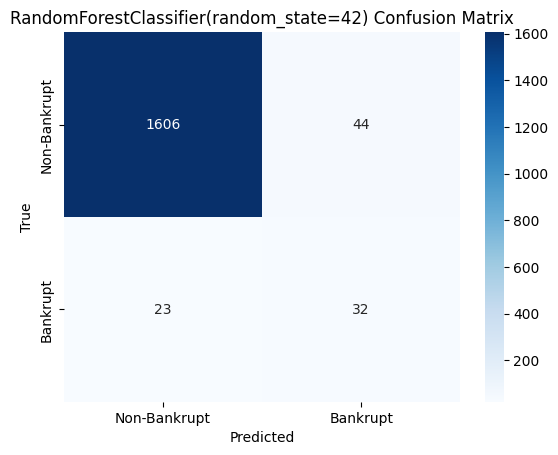

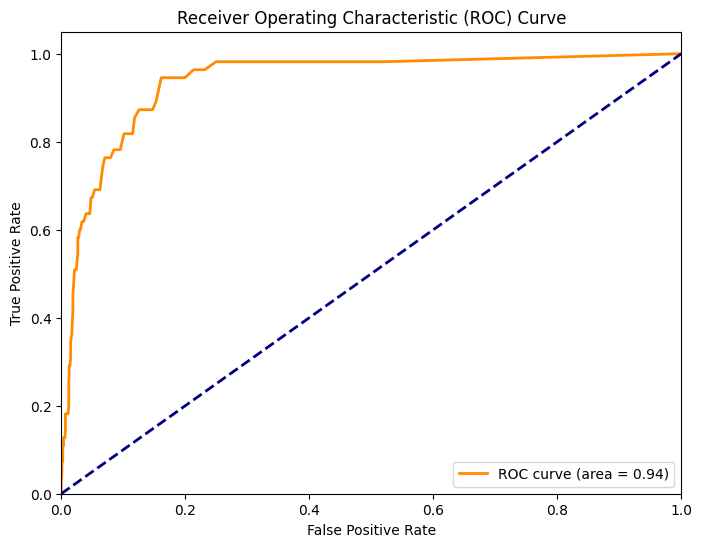

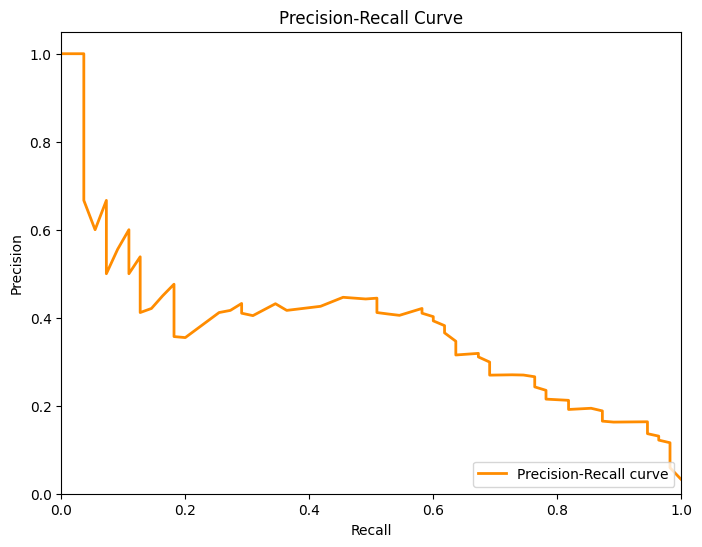

In [20]:
visualize_metrics(rf_model, X_test, y_test)

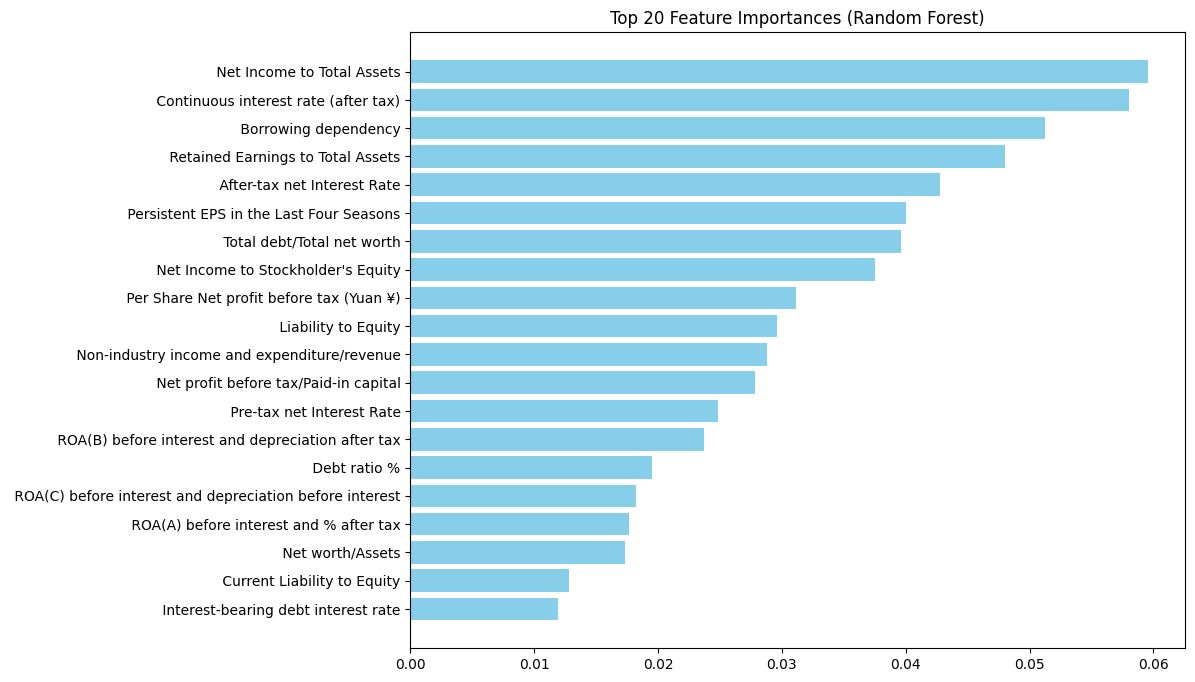

In [21]:
interpret_model_feat_importance(rf_model, X_train_resampled, df)

#### XGBoost

In [ ]:
# top_20_df = df[[' After-tax net Interest Rate',
#  ' Continuous interest rate (after tax)',
# ' Net Income to Total Assets',
#  ' Retained Earnings to Total Assets',
#  ' Pre-tax net Interest Rate',
#  ' Total debt/Total net worth',
#  ' Total income/Total expense',
#  ' Per Share Net profit before tax (Yuan ¥)',
#  ' ROA(A) before interest and % after tax',
#  ' Persistent EPS in the Last Four Seasons'
# ]]
# top_20_df.head()

In [21]:
X_train, X_test, y_train, y_test = split_data(df)
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

In [22]:
xgb_model = train_model(X_train_resampled, y_train_resampled, model_type='xgboost', model_params={'n_estimators':100, 'random_state':42})

In [ ]:
# # With grid search
# xgb_param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_lambda': [0, 1, 10]
# }
# xgb_model_grid = train_model_gridsearch(X_train_resampled, y_train_resampled, 
#                                        model_type='xgboost', 
#                                        model_params={'n_estimators':100, 'random_state':42}, 
#                                        use_gridsearch=True, param_grid=xgb_param_grid, scoring='f1', cv=3)

In [ ]:
y_pred = make_y_predictions(xgb_model, X_test)

In [ ]:
evaluate_metrics(xgb_model, X_test, y_test)

F1-Score: 0.5636363636363636
Precision: 0.5636363636363636
Recall: 0.5636363636363636
AUC-ROC: 0.968099173553719

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1650
           1       0.56      0.56      0.56        55

    accuracy                           0.97      1705
   macro avg       0.77      0.77      0.77      1705
weighted avg       0.97      0.97      0.97      1705




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
 Confusion Matrix:


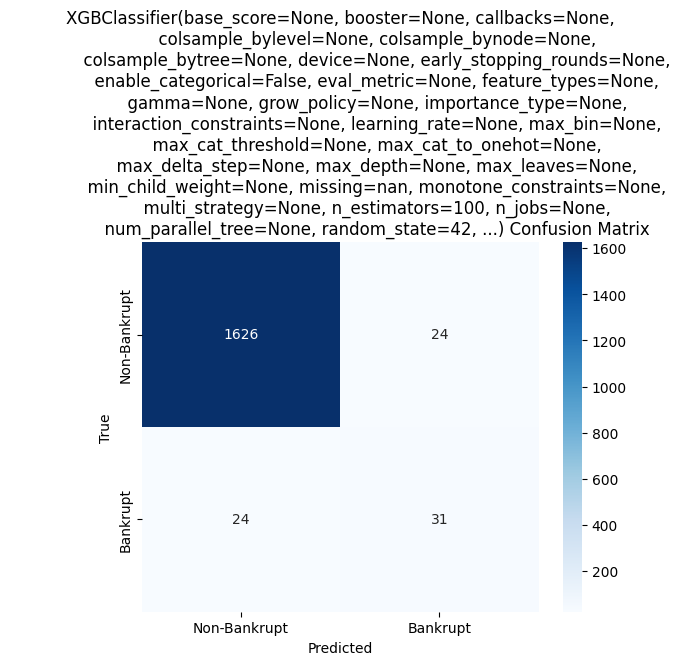

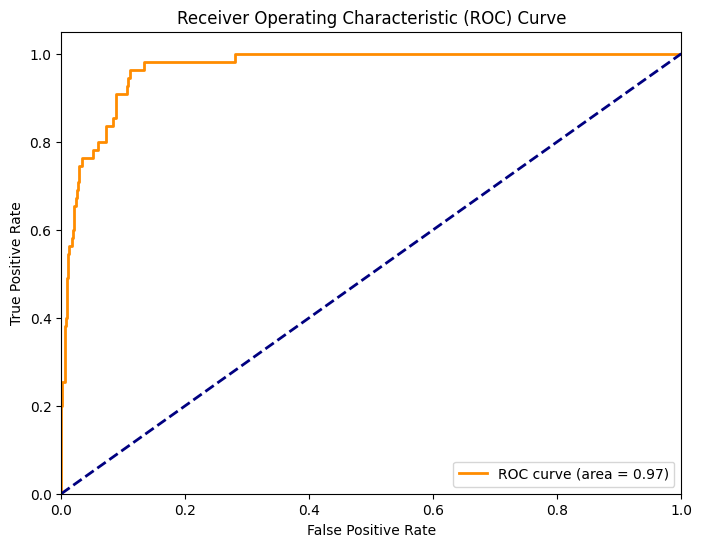

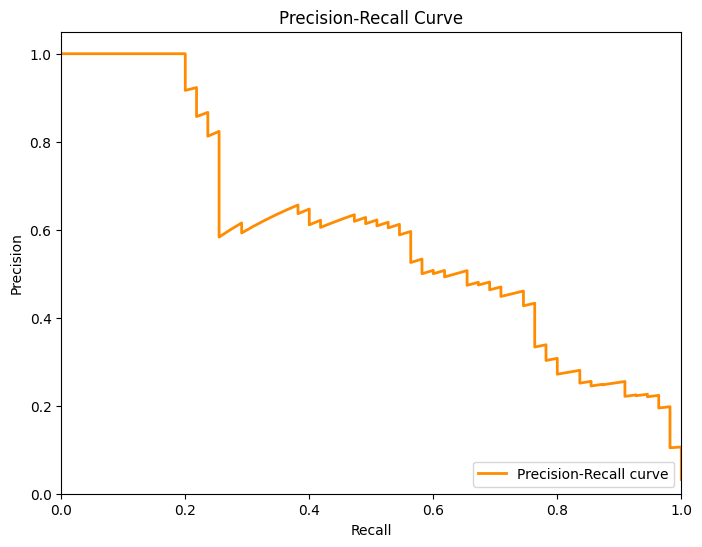

In [ ]:
visualize_metrics(xgb_model, X_test, y_test)

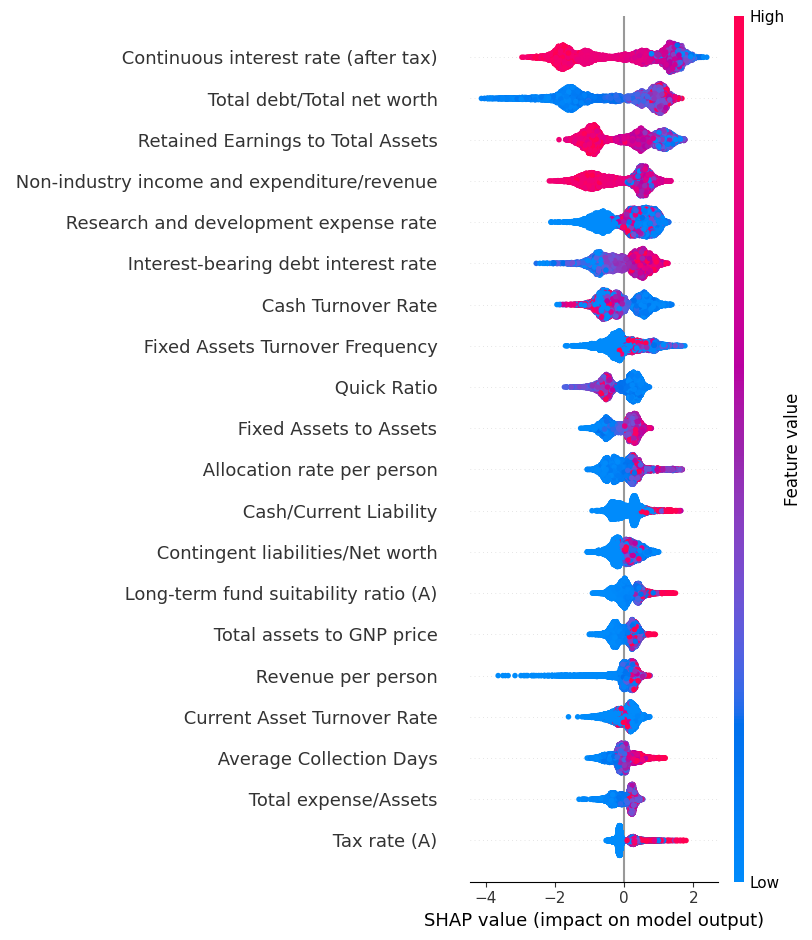

In [ ]:
interpret_model_shap(xgb_model, X_train_resampled, df)

### In Conclusion

The best model is the XGBoost.